<a href="https://colab.research.google.com/github/sandhyaparna/NLP/blob/main/Dell_Take_Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
from google.colab import files
import json
import seaborn as sns
import matplotlib.pyplot as plt
import string, re, os
import collections
from collections import defaultdict, Counter, OrderedDict

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['i']
stop_words = stop_words + more_stopwords

import spacy
nlp = spacy.load('en', parse = False, tag=False, entity=False)

from wordcloud import WordCloud
import textblob
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)

In [3]:
print("upload boston_bombing_tweets - Home test Data Scientist.csv file")
tweets_uploaded = files.upload()

upload boston_bombing_tweets - Home test Data Scientist.csv file


Saving boston_bombing_tweets - Home test Data Scientist.csv to boston_bombing_tweets - Home test Data Scientist.csv


In [4]:
print("upload replacements_dict.json file")
dict_uploaded = files.upload()

upload replacements_dict.json file


Saving replacements_dict.json to replacements_dict.json


In [5]:
import io
boston_bombing_tweets = pd.read_csv(io.BytesIO(tweets_uploaded['boston_bombing_tweets - Home test Data Scientist.csv']))
print(f'Tweets data is loaded')

tweets_train = boston_bombing_tweets[pd.notnull(boston_bombing_tweets.label)]
print("Number of observations in train data are", tweets_train.shape[0])

tweets_test = boston_bombing_tweets[pd.isnull(boston_bombing_tweets.label)]
print("Number of observations in test data are", tweets_test.shape[0])

Tweets data is loaded
Number of observations in train data are 4000
Number of observations in test data are 12218


In [6]:
with open('replacements_dict.json') as json_file:
  replacements_dict = json_file.readlines()
  
replacements_dict = map(lambda x: x.rstrip(), replacements_dict)
replacements_dict = ' '.join(replacements_dict)
replacements_dict = json.loads(replacements_dict, object_pairs_hook=OrderedDict)
print("replacements dictionary is loaded")

replacements dictionary is loaded


In [7]:
# helper functions
def replace_all(text, dic=replacements_dict):
    for i, j in dic.items():
        text = re.sub(i, j, text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
    
def text_preprocess(text):
  text = re.sub('[%s]' % re.escape(string.punctuation.replace('#','')), '', text)
  text = re.sub('^# |# ', '', text)
  text = re.sub('[^\u0000-\u007e]+', '', text)
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)
  return text

def create_corpus(data, text_var, condition):
    corpus=[]
    
    if condition == "hash":
      for x in data['text_processed'].apply(lambda x: re.findall(r'(?<=)#\w+',x)):
          for i in x:
            corpus.append(i)
    
    else:  # non-hash words
      for x in data['text_processed'].apply(lambda x: re.findall(r'(?#)\w+',x)):
        for i in x:
          corpus.append(i)

    return corpus

def get_top_tweet_ngrams(corpus, n):
    vec = CountVectorizer(ngram_range=(n, n), token_pattern=r'\b\w\w+\b|(?<!\w)#\w+').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:None]

In [8]:
# pre-processing function
def preprocessing_fn(data, text_var):
  """
  delete missing values, 

  """
  data = data[pd.notnull(data[text_var])]
  data[text_var+'_processed'] = data[text_var].str.lower()
  data[text_var+'_URL_present'] = np.where(data[text_var+'_processed'].str.contains("http://"),1,0)
  data[text_var+'_retweet'] = np.where(data[text_var+'_processed'].str.contains("rt @"),1, 0)

  data[text_var+'_processed'] = data[text_var+'_processed'].apply(lambda x: replace_all(x,replacements_dict))
  data[text_var+'_punctuations_count'] = data[text_var+'_processed'].apply(lambda x: re.findall('[%s]' % re.escape(string.punctuation),str(x))).str.len() 
  data[text_var+'_word_count'] = data[text_var+'_processed'].apply(lambda x: len(str(x).split()))
  data[text_var+'_hashtag_count'] = data[text_var+'_processed'].apply(lambda x: len([c for c in str(x) if c == '#']))
  
  data[text_var+'_processed'] = data[text_var+'_processed'].apply(lambda x: lemmatize_text(x))
  data[text_var+'_processed'] = data[text_var+'_processed'].apply(lambda x: text_preprocess(x))

  return data

In [15]:
# feature engineering of n-grams
def feature_engineering(data):
  features = []

  for i, j in Counter(create_corpus(data, "text_processed", "non-hash")).items():
    if j > 30:
      features.append(i)

  for i, j in Counter(create_corpus(data, "text_processed", "hash")).items():
    if j > 10:
      features.append(i)

  for i, j in get_top_tweet_ngrams(data["text_processed"], 2):
    if j > 10:
      features.append(i)

  for i, j in get_top_tweet_ngrams(data["text_processed"], 3):
    if j > 5:
      features.append(i)

  print(features)
  print(len(features))

  for i in features:
    data[i+"_ngram"] = np.where(data["text_processed"].str.contains(i),1,0)
  
  data.columns = data.columns.str.replace(' ', '_')
  
  return data

In [16]:
tweets_train_x = feature_engineering(preprocessing_fn(tweets_train, "text"))
tweets_train_x.head()

['report', 'suspect', 'custody', 'man', 'terrorist', 'still', 'boat', 'dzhokhar', 'tsarnaev', 'terror', 'president', 'street', 'watertown', 'boston', 'old', 'day', 'one', 'win', 'look', 'job', 'cambridge', 'bomb', 'attack', 'let', 'us', 'make', 'great', 'thing', 'like', 'bostonstrong', 'never', 'find', 'give', 'heart', 'get', 'time', 'want', 'dead', 'marathon', 'bombing', 'start', 'prayforboston', 'happen', 'prayer', 'go', 'family', 'come', 'tonight', 'back', 'good', 'first', 'place', 'new', 'run', 'event', 'even', 'police', 'everyone', 'today', 'city', 'home', 'life', 'tamerlan', 'via', 'pray', 'world', 'bostonmarathon', 'service', 'assistant', 'area', 'week', 'work', 'software', 'manager', 'two', 'see', 'team', 'help', 'w', 'friend', 'update', 'manhunt', 'think', 'would', 'l', 'celtic', 'ticket', 'snow', 'tomorrow', 'year', 'love', 'high', 'full', 'right', 'talk', 'use', 'house', 'know', 'victim', 'please', 'many', 'take', 'live', 'redsox', 'official', 'say', 'brother', 'game', 'engi

,text,label,text_processed,text_URL_present,text_retweet,text_punctuations_count,text_word_count,text_hashtag_count,report_ngram,suspect_ngram,custody_ngram,man_ngram,terrorist_ngram,still_ngram,boat_ngram,dzhokhar_ngram,tsarnaev_ngram,terror_ngram,president_ngram,street_ngram,watertown_ngram,boston_ngram,old_ngram,day_ngram,one_ngram,win_ngram,look_ngram,job_ngram,cambridge_ngram,bomb_ngram,attack_ngram,let_ngram,us_ngram,make_ngram,great_ngram,thing_ngram,like_ngram,bostonstrong_ngram,never_ngram,find_ngram,give_ngram,heart_ngram,get_ngram,time_ngram,want_ngram,dead_ngram,marathon_ngram,bombing_ngram,start_ngram,prayforboston_ngram,happen_ngram,prayer_ngram,go_ngram,family_ngram,come_ngram,tonight_ngram,back_ngram,good_ngram,first_ngram,place_ngram,new_ngram,run_ngram,event_ngram,even_ngram,police_ngram,everyone_ngram,today_ngram,city_ngram,home_ngram,life_ngram,tamerlan_ngram,via_ngram,pray_ngram,world_ngram,bostonmarathon_ngram,service_ngram,assistant_ngram,area_ngram,week_ngram,work_ngram,software_ngram,manager_ngram,two_ngram,see_ngram,team_ngram,help_ngram,w_ngram,friend_ngram,update_ngram,manhunt_ngram,think_ngram,would_ngram,l_ngram,celtic_ngram,ticket_ngram,snow_ngram,tomorrow_ngram,year_ngram,love_ngram,high_ngram,full_ngram,right_ngram,talk_ngram,use_ngram,house_ngram,know_ngram,victim_ngram,please_ngram,many_ngram,take_ngram,live_ngram,redsox_ngram,official_ngram,say_ngram,brother_ngram,game_ngram,engineer_ngram,news_ngram,scene_ngram,believe_ngram,end_ngram,fbi_ngram,hope_ngram,mass_ngram,senior_ngram,morning_ngram,tell_ngram,tragedy_ngram,stop_ngram,guy_ngram,school_ngram,open_ngram,feel_ngram,show_ngram,big_ngram,massachusetts_ngram,anyone_ngram,law_ngram,sale_ngram,bos_ngram,seek_ngram,next_ngram,capture_ngram,really_ngram,people_ngram,stay_ngram,could_ngram,last_ngram,hour_ngram,thank_ngram,community_ngram,bruin_ngram,st_ngram,college_ngram,may_ngram,student_ngram,photo_ngram,officer_ngram,way_ngram,rt_ngram,need_ngram,night_ngram,call_ngram,break_ngram,part_ngram,kill_ngram,arrest_ngram,watch_ngram,fire_ngram,monday_ngram,video_ngram,nba_ngram,celtics_ngram,support_ngram,red_ngram,state_ngram,search_ngram,hire_ngram,join_ngram,well_ngram,business_ngram,keep_ngram,scanner_ngram,hear_ngram,move_ngram,much_ngram,post_ngram,boston_job_ngram,dzhokhar_tsarnaev_ngram,job_boston_ngram,boston_marathon_ngram,bos_boston_ngram,boston_celtics_ngram,marathon_attack_ngram,bombing_suspect_ngram,boston_news_ngram,year_old_ngram,tamerlan_tsarnaev_ngram,boston_police_ngram,suspect_custody_ngram,suspect_dzhokhar_ngram,marathon_bombing_ngram,news_boston_ngram,boston_boston_ngram,cambridge_job_ngram,boston_prayforboston_ngram,let_us_ngram,part_time_ngram,terrorist_attack_ngram,boston_area_ngram,manager_boston_ngram,terror_attack_ngram,watertown_manhunt_ngram,come_boston_ngram,bostonmarathon_prayforboston_ngram,bomb_suspect_ngram,watertown_boston_ngram,manhunt_watertown_ngram,marathon_terror_ngram,law_enforcement_ngram,terror_bombing_ngram,red_sox_ngram,go_boston_ngram,boston_watertown_ngram,boston_bombing_ngram,boston_redsox_ngram,boston_common_ngram,full_time_ngram,bostonstrong_prayforboston_ngram,break_news_ngram,back_boston_ngram,prayforboston_bostonstrong_ngram,attack_boston_ngram,prayer_go_ngram,tsarnaev_cambridge_ngram,police_officer_ngram,thought_prayer_ngram,boston_college_ngram,state_police_ngram,day_boston_ngram,boston_bomb_ngram,boston_terror_ngram,software_engineer_ngram,city_boston_ngram,hunt_search_ngram,search_terror_ngram,terror_justice_ngram,justice_win_ngram,join_us_ngram,look_like_ngram,job_cambridge_ngram,prayforboston_bostonmarathon_ngram,tsarnaev_brother_ngram,boston_attack_ngram,last_night_ngram,boston_red_ngram,capture_hunt_ngram,dzhokar_tsarnaev_ngram,today_prayforboston_ngram,boston_bruins_ngram,boston_bruin_ngram,new_bedford_ngram,bombing_investigation_ngram,bostonmarathon_attack_ngram,win_suspect_ngram,prayforboston_prayfortexas_ngram,despite_report_ngram,report_contrary_ngram,contrary_arrest_ngram,arr

In [17]:
# train = feature_engineering(preprocessing_fn(data, text_var))
train = tweets_train_x.drop(['text', 'text_processed'],axis=1)
train.head()

,label,text_URL_present,text_retweet,text_punctuations_count,text_word_count,text_hashtag_count,report_ngram,suspect_ngram,custody_ngram,man_ngram,terrorist_ngram,still_ngram,boat_ngram,dzhokhar_ngram,tsarnaev_ngram,terror_ngram,president_ngram,street_ngram,watertown_ngram,boston_ngram,old_ngram,day_ngram,one_ngram,win_ngram,look_ngram,job_ngram,cambridge_ngram,bomb_ngram,attack_ngram,let_ngram,us_ngram,make_ngram,great_ngram,thing_ngram,like_ngram,bostonstrong_ngram,never_ngram,find_ngram,give_ngram,heart_ngram,get_ngram,time_ngram,want_ngram,dead_ngram,marathon_ngram,bombing_ngram,start_ngram,prayforboston_ngram,happen_ngram,prayer_ngram,go_ngram,family_ngram,come_ngram,tonight_ngram,back_ngram,good_ngram,first_ngram,place_ngram,new_ngram,run_ngram,event_ngram,even_ngram,police_ngram,everyone_ngram,today_ngram,city_ngram,home_ngram,life_ngram,tamerlan_ngram,via_ngram,pray_ngram,world_ngram,bostonmarathon_ngram,service_ngram,assistant_ngram,area_ngram,week_ngram,work_ngram,software_ngram,manager_ngram,two_ngram,see_ngram,team_ngram,help_ngram,w_ngram,friend_ngram,update_ngram,manhunt_ngram,think_ngram,would_ngram,l_ngram,celtic_ngram,ticket_ngram,snow_ngram,tomorrow_ngram,year_ngram,love_ngram,high_ngram,full_ngram,right_ngram,talk_ngram,use_ngram,house_ngram,know_ngram,victim_ngram,please_ngram,many_ngram,take_ngram,live_ngram,redsox_ngram,official_ngram,say_ngram,brother_ngram,game_ngram,engineer_ngram,news_ngram,scene_ngram,believe_ngram,end_ngram,fbi_ngram,hope_ngram,mass_ngram,senior_ngram,morning_ngram,tell_ngram,tragedy_ngram,stop_ngram,guy_ngram,school_ngram,open_ngram,feel_ngram,show_ngram,big_ngram,massachusetts_ngram,anyone_ngram,law_ngram,sale_ngram,bos_ngram,seek_ngram,next_ngram,capture_ngram,really_ngram,people_ngram,stay_ngram,could_ngram,last_ngram,hour_ngram,thank_ngram,community_ngram,bruin_ngram,st_ngram,college_ngram,may_ngram,student_ngram,photo_ngram,officer_ngram,way_ngram,rt_ngram,need_ngram,night_ngram,call_ngram,break_ngram,part_ngram,kill_ngram,arrest_ngram,watch_ngram,fire_ngram,monday_ngram,video_ngram,nba_ngram,celtics_ngram,support_ngram,red_ngram,state_ngram,search_ngram,hire_ngram,join_ngram,well_ngram,business_ngram,keep_ngram,scanner_ngram,hear_ngram,move_ngram,much_ngram,post_ngram,boston_job_ngram,dzhokhar_tsarnaev_ngram,job_boston_ngram,boston_marathon_ngram,bos_boston_ngram,boston_celtics_ngram,marathon_attack_ngram,bombing_suspect_ngram,boston_news_ngram,year_old_ngram,tamerlan_tsarnaev_ngram,boston_police_ngram,suspect_custody_ngram,suspect_dzhokhar_ngram,marathon_bombing_ngram,news_boston_ngram,boston_boston_ngram,cambridge_job_ngram,boston_prayforboston_ngram,let_us_ngram,part_time_ngram,terrorist_attack_ngram,boston_area_ngram,manager_boston_ngram,terror_attack_ngram,watertown_manhunt_ngram,come_boston_ngram,bostonmarathon_prayforboston_ngram,bomb_suspect_ngram,watertown_boston_ngram,manhunt_watertown_ngram,marathon_terror_ngram,law_enforcement_ngram,terror_bombing_ngram,red_sox_ngram,go_boston_ngram,boston_watertown_ngram,boston_bombing_ngram,boston_redsox_ngram,boston_common_ngram,full_time_ngram,bostonstrong_prayforboston_ngram,break_news_ngram,back_boston_ngram,prayforboston_bostonstrong_ngram,attack_boston_ngram,prayer_go_ngram,tsarnaev_cambridge_ngram,police_officer_ngram,thought_prayer_ngram,boston_college_ngram,state_police_ngram,day_boston_ngram,boston_bomb_ngram,boston_terror_ngram,software_engineer_ngram,city_boston_ngram,hunt_search_ngram,search_terror_ngram,terror_justice_ngram,justice_win_ngram,join_us_ngram,look_like_ngram,job_cambridge_ngram,prayforboston_bostonmarathon_ngram,tsarnaev_brother_ngram,boston_attack_ngram,last_night_ngram,boston_red_ngram,capture_hunt_ngram,dzhokar_tsarnaev_ngram,today_prayforboston_ngram,boston_bruins_ngram,boston_bruin_ngram,new_bedford_ngram,bombing_investigation_ngram,bostonmarathon_attack_ngram,win_suspect_ngram,prayforboston_prayfortexas_ngram,despite_report_ngram,report_contrary_ngram,contrary_arrest_ngram,arrest_marathon_ngram,s

In [18]:
# Split data into 80% Train & 20% Test - Stratified split
X = train.drop(['label'],axis=1)
y = train[['label']]

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
# Create a Multinomial Naive Bayes model
nb = MultinomialNB()

# Train the model
nb.fit(X_train, y_train)

# Make class anf probability predictions
y_pred_class = nb.predict(X_eval)
y_pred_prob = nb.predict_proba(X_eval)[:, 1]

Performance evaluation of Logistic Regression Model
Confusion Matrix 
 Predicted  0.0  1.0  All
True                    
0.0        392  11   403
1.0        0    397  397
All        392  408  800

 Classification Report 
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       403
         1.0       0.97      1.00      0.99       397

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



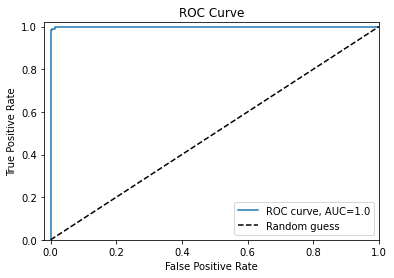

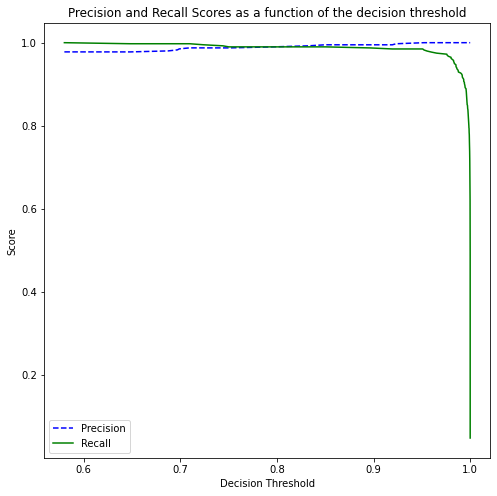

In [20]:
# Bi-grams & Tri-grams
print("Performance evaluation of Logistic Regression Model")

print("Confusion Matrix","\n",pd.crosstab(y_eval.label, y_pred_class, rownames=['True'], colnames=['Predicted'], margins=True))

print("\n","Classification Report","\n",classification_report(y_eval, y_pred_class))

fpr, tpr, thresholds = roc_curve(y_eval, y_pred_prob)
# create plot
plt.plot(fpr, tpr, label='ROC curve'+', AUC='+str(round(roc_auc_score(y_eval, y_pred_prob).mean(),3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")


precision, recall, thresholds = precision_recall_curve(y_eval, y_pred_prob)
# Create plot
plt.figure(figsize=(8, 8))
plt.title("Precision and Recall Scores as a function of the decision threshold")
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc='best') 

Performance evaluation of Logistic Regression Model
Confusion Matrix 
 Predicted  0.0  1.0  All
True                    
0.0        383  20   403
1.0        0    397  397
All        383  417  800

 Classification Report 
               precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       403
         1.0       0.95      1.00      0.98       397

    accuracy                           0.97       800
   macro avg       0.98      0.98      0.97       800
weighted avg       0.98      0.97      0.97       800



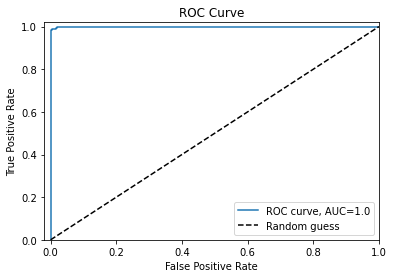

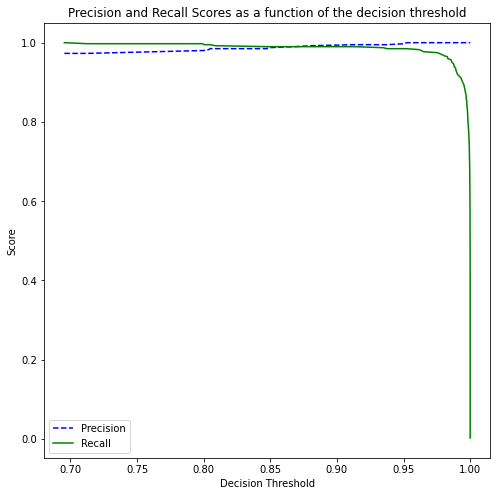

In [14]:
# Uni-grams
print("Performance evaluation of Logistic Regression Model")

print("Confusion Matrix","\n",pd.crosstab(y_eval.label, y_pred_class, rownames=['True'], colnames=['Predicted'], margins=True))

print("\n","Classification Report","\n",classification_report(y_eval, y_pred_class))

fpr, tpr, thresholds = roc_curve(y_eval, y_pred_prob)
# create plot
plt.plot(fpr, tpr, label='ROC curve'+', AUC='+str(round(roc_auc_score(y_eval, y_pred_prob).mean(),3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")


precision, recall, thresholds = precision_recall_curve(y_eval, y_pred_prob)
# Create plot
plt.figure(figsize=(8, 8))
plt.title("Precision and Recall Scores as a function of the decision threshold")
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc='best') 

In [ ]:
fpr, tpr, thresholds = roc_curve(project_data_y_test,project_data_y_test_Prediction_logistic_prob)
# create plot
plt.plot(fpr, tpr, label='ROC curve'+', AUC='+str(round(roc_auc_score(project_data_y_test, project_data_y_test_Prediction_logistic_prob).mean(),3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")


precision, recall, thresholds = precision_recall_curve(project_data_y_test,project_data_y_test_Prediction_logistic_prob)
# Create plot
plt.figure(figsize=(8, 8))
plt.title("Precision and Recall Scores as a function of the decision threshold")
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc='best') 

In [ ]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

In [ ]:
tweets_train_x[["text", "text_processed"]].head()

In [ ]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig